In [7]:
import psycopg2
import pandas as pd

import numpy as np

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLars

from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Query modeling_data2 table from PostgreSQL database

try:
    conn = psycopg2.connect(user="cohort17",
                            password="Cohort17Movies",
                            host="moviesdb.ce8d6g1pa5lm.us-east-1.rds.amazonaws.com",
                            port="5432",database="moviesdb")

    dbquery = "select * from modeling_data2"
    
    movies = pd.read_sql_query(dbquery, conn)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    if(conn):
        conn.close()

In [4]:
X = movies.drop(['primarytitle','domesticgross'], axis=1)
y = movies['domesticgross']

numeric_features = X[['productionbudget','runtimeminutes','release_year','release_week']].columns
dummy_features = X.drop(numeric_features, axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [5]:
impute_numeric = SimpleImputer(missing_values=np.nan, strategy='median', copy=False, fill_value=None)
impute_dummy = SimpleImputer(missing_values=np.nan, strategy='constant', copy=False, fill_value=0)

scale_numeric = MinMaxScaler(copy=False)

numeric_transformer = Pipeline(steps=[
    ('imputer', impute_numeric),
    ('scaler', scale_numeric)])

dummy_transformer = Pipeline(steps=[
    ('imputer', impute_dummy)])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('dum', dummy_transformer, dummy_features)])

In [6]:
regressors = [
    RandomForestRegressor(n_estimators=100, random_state=0),
    ElasticNetCV(max_iter=1000, cv=5, random_state=0, l1_ratio=[.1, .3, .5, .7, .9, .95, .99, 1]),
    LassoLars(max_iter=1000),
    GradientBoostingRegressor(random_state=0)
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)
    print("model score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
model score: 0.557
ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
             verbose=0)
model score: 0.540
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=1000, normalize=True,

In [45]:
gbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=0))])
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test)

0.5794720892443368

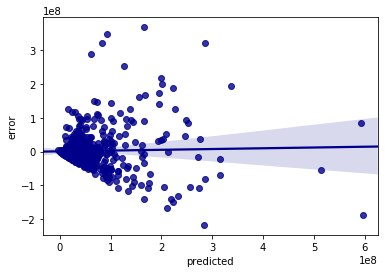

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pred_actual = pd.DataFrame({'predicted':gbm.predict(X_test),'actual':y_test})
pred_actual['pred_rank'] = pred_actual['predicted'].rank()
pred_actual['error'] = pred_actual['actual'] - pred_actual['predicted']
pred_actual.sort_values(by=['pred_rank'],inplace=True)

sns.regplot(data=pred_actual,x='predicted',y='error', color="darkblue")

In [22]:
dump(gbm, 'gbm_1.joblib')

['gbm_1.joblib']

In [47]:
gbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(regressor=GradientBoostingRegressor(random_state=0),func=np.log, inverse_func=np.exp))])
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test)

0.4315800022290658

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


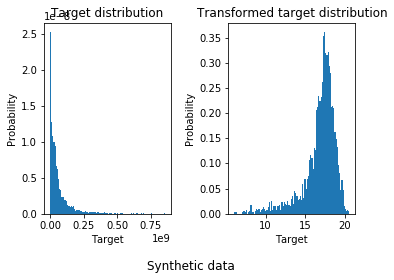

In [48]:


y_trans = np.log1p(y)
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, normed=True)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, normed=True)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

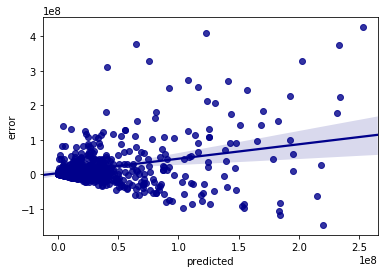

In [51]:
pred_actual = pd.DataFrame({'predicted':gbm.predict(X_test),'actual':y_test})
pred_actual['pred_rank'] = pred_actual['predicted'].rank()
pred_actual['error'] = pred_actual['actual'] - pred_actual['predicted']
pred_actual.sort_values(by=['pred_rank'],inplace=True)


sns.regplot(data=pred_actual,x='predicted',y='error', color="darkblue")